# Stock Predictions

## Imports

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',100)

In [25]:
df = yf.download('SPY')

[*********************100%***********************]  1 of 1 completed


In [27]:
df.index = pd.to_datetime(df.index)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.941406,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.118784,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.171993,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.438101,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.544529,531500
...,...,...,...,...,...,...
2023-11-30,455.480011,456.760010,453.339996,456.399994,456.399994,79752700
2023-12-01,455.769989,459.649994,455.160004,459.100006,459.100006,89097900
2023-12-04,455.600006,459.119995,454.339996,456.690002,456.690002,72430900


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7770 entries, 1993-01-29 to 2023-12-06
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       7770 non-null   float64
 1   High       7770 non-null   float64
 2   Low        7770 non-null   float64
 3   Close      7770 non-null   float64
 4   Adj Close  7770 non-null   float64
 5   Volume     7770 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 424.9 KB


In [31]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7770.000000,7770.000000,7770.000000,7770.000000,7770.000000,7.770000e+03
mean,169.834751,170.854882,168.712347,169.841808,141.959410,8.447769e+07
std,105.883612,106.454959,105.274316,105.906543,112.018433,9.242272e+07
min,43.343750,43.531250,42.812500,43.406250,24.639820,5.200000e+03
25%,105.200003,106.012503,104.352499,105.181875,70.883957,9.942825e+06
50%,132.071251,132.860001,131.070007,131.974998,93.763607,6.295260e+07
75%,209.932499,210.792503,209.107502,210.070007,181.609985,1.160220e+08
max,479.220001,479.980011,476.059998,477.709991,464.923401,8.710263e+08


## Custom Functions

In [15]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [16]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [45]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [18]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [19]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [20]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [21]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [22]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [23]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

## Perform Train/Test Split

In [28]:
y = spy['Close'].copy()
X = spy.drop(columns=['Close'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

,Open,High,Low,Adj Close,Volume
Date,,,,,
2006-09-14,131.960007,132.240005,131.750000,94.706772,57805400
2015-07-29,209.479996,211.039993,209.309998,181.761566,105791300
2010-10-15,118.279999,118.349998,116.760002,92.155479,243705000
2020-03-05,304.980011,308.470001,300.010010,285.166595,186366800
1993-10-21,46.687500,46.687500,46.531250,26.929226,56200


In [30]:
num_sel = make_column_selector(dtype_include='number')

In [32]:
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [34]:
preprocessor = make_column_transformer((num_pipe, num_sel), verbose_feature_names_out=False)

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Open,High,Low,Adj Close,Volume
Date,,,,,
1998-09-15,102.875000,104.312500,102.281250,66.273239,8337900.0
2003-12-24,109.519997,109.879997,109.430000,75.070793,8055800.0
2006-11-13,138.179993,139.039993,138.070007,99.691315,59398200.0


In [36]:
y_test.head(3)

Date
1998-09-15    104.062500
2003-12-24    109.620003
2006-11-13    138.580002
Name: Close, dtype: float64

In [37]:
# fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.85
Test Data:	R^2= 1.00	RMSE= 0.82


In [38]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

Open        -6.461534e-01
Volume      -2.707347e-10
Adj Close    1.019101e-02
intercept    3.875819e-01
Low          7.968119e-01
High         8.390011e-01
dtype: float64

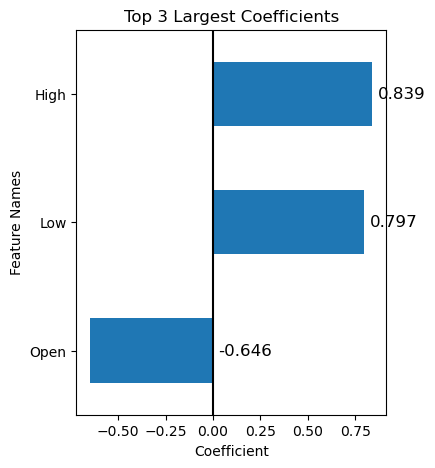

In [46]:
plot_coeffs(coeffs, top_n=3,annotate=True);

## Random Forest

In [47]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df, y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.36
Test Data:	R^2= 1.00	RMSE= 0.99


In [48]:
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

Open         0.062175
High         0.119719
Low          0.707897
Adj Close    0.110200
Volume       0.000009
Name: Feature Importance, dtype: float64

In [49]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

Low          0.707897
High         0.119719
Adj Close    0.110200
Open         0.062175
Volume       0.000009
Name: Feature Importance, dtype: float64

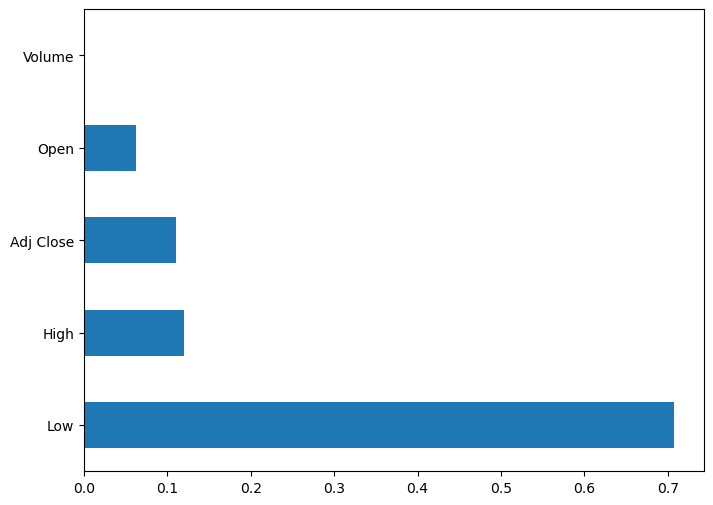

In [51]:
## just keep the top 5 importances and plot
sorted_importance.head(5).plot(kind='barh',
                                   figsize=(8,6));

In [52]:
corr = df.corr()

In [53]:
plt.figure

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999937,0.999919,0.999860,0.996826,0.088988
High,0.999937,1.000000,0.999868,0.999914,0.996906,0.091458
Low,0.999919,0.999868,1.000000,0.999923,0.996879,0.085574
Close,0.999860,0.999914,0.999923,1.000000,0.996973,0.088182
Adj Close,0.996826,0.996906,0.996879,0.996973,1.000000,0.099689
Volume,0.088988,0.091458,0.085574,0.088182,0.099689,1.000000
